# 1. Giới thiệu SSD model

Như chúng ta đã biết có khá nhiều các lớp mô hình khác nhau trong phát hiện vật thể. Các kiến trúc cũ hơn có thể kể đến như R-CNN, fast R-CNN. Đặc điểm của chúng là tốc độ xử lý thấp, không đáp ứng được trong việc object dection realtime. Các mạng start-of-art hơn như SSD và YOLOv2, YOLOv3 là những kiến trúc có tốc độ xử lý nhanh mà vẫn đảm bảo về độ chính xác nhờ những thay đổi trong kiến trúc mạng nhằm gói gọn quá trình phát hiện và phân loại vật thể trong 1 lần và cắt bớt được các xử lý không cần thiết.

Trong bài này chúng ta sẽ tìm hiểu về kiến trúc, cách thức hoạt động đi kèm ví dụ thực tiễn để xây dựng một lớp mô hình SSD (Single Shot MultiBox Detector) trong object detection. 

Cũng giống như hầu hết các kiến trúc object detection khác, đầu vào của SSD là tọa độ bounding box của vật thể (hay còn gọi là offsets của bounding box) và nhãn của vật thể chứa trong bounding box. Điểm đặc biệt làm nên tốc độ của SSD model là mô hình sử dụng một mạng neural duy nhất. Cách tiếp cận của nó dựa trên việc nhận diện vật thể trong các features map (là một output shape 3D của một mạng deep CNN sau khi bỏ các fully connected layers cuối) có độ phân giải khác nhau. Mô hình sẽ tạo ra một lưới các ô vuông gọi là grid cells trên các feature map, mỗi ô được gọi là một cell và từ tâm của mỗi cell xác định một tợp hợp các boxes mặc định (default boxes) để dự đoán khung hình có khả năng bao quanh vật thể.  Tại thời điểm dự báo, mạng neural sẽ trả về 2 giá trị đó là: phân phối xác suất nhãn của vật thể chứa trong bounding box và một tọa độ gọi là offsets của bounding box. Quá trình huấn luyện cũng là quá trình tinh chỉnh xác suất nhãn và bounding box về đúng với các giá trị ground truth input của mô hình (gồm nhãn và offsets bounding box). 

Thêm nữa, network được kết hợp bởi rất nhiều các feature map với những độ phân giải khác nhau để giúp phát hiện được những vật thể có kích thước to và nhỏ. Trái với mô hình fast R-CNN, SSD bỏ qua bước sản sinh ra một mặt nạ region proposal network để đề xuất vùng vật thể. Thay vào đó tất cả quá trình phát hiện vật thể và phân loại vật thể được thực hiện trong cùng 1 mạng. Bản thân tên của mô hình - Single Shot MultiBox Detector cũng nói lên được rằng mô hình sử dụng nhiều khung hình box với tỷ lệ scales khác nhau để nhận diện vùng vật thể và phân loại vật thể, giảm thiểu được bước tạo region proposal network so với fast R-CNN nên tăng tốc độ xử lý lên nhiều lần mà tốc độ xử lý vẫn đảm bảo.
Bên dưới là bảng so sánh tốc độ running của các mô hình


![](https://imgur.com/WQIvw2C.png)

**Hình 1**: Bảng so sánh tốc độ xử lý và độ chính xác của các lớp model object detection (source: [table 7 - SSD: Single Shot MultiBox Detector
](https://arxiv.org/pdf/1512.02325.pdf)). Ta thấy SSD512 (mô hình SSD với kích thước đầu vào của ảnh là 512 x 512 x 3) có độ chính xác mAP là cao nhất trong khi tốc độ xử lý gần đạt mức realtime là 22 fps.

Tóm gọn lại mô hình SSD sẽ là kết hợp của 2 bước:

* Trích xuất các feature map từ mạng CNN.
* Áp dụng convolutional filters (hoặc kernel filters) để phát hiện vật thể trên các feature map có độ phân giải (revolution) khác nhau.

# Một số định nghĩa
* **scale**: Tỷ lệ chiều dài và chiều rộng so với khung hình gốc. VD: Nếu khung hình gốc có giá trị là $(w, h)$ thì sau scale khung hình mới có kích thước là $(sw, sh)$. Gía trị của $s$ thường nằm trong khoảng $s \in (0, 1]$. Scale sẽ kết hợp với aspect ratio để nhận được các khung hình có tỷ lệ cạnh $w/h$ khác nhau.
* **aspect ratio**: Tỷ lệ hướng, được đo bằng tỷ lệ giữa $w/h$ nhằm xác định hình dạng tương đối của khung hình bao chứa vật thể. Chẳng hạn nếu vật thể là người thường có aspect ratio = $1:3$ hoặc xe cộ nhìn từ phía trước là $1:1$.
* **bounding box**: Khung hình bao chứa vật thể được xác định trong quá trình huấn luyện.
* **ground truth box**: Khung hình được xác định trước từ bộ dữ liệu thông qua tọa độ $(c_x, c_y , w, h)$ giúp xác định vật thể.
* **offsets**: Các tọa độ $(c_x, c_y , w, h)$ để xác định vật thể.
* **positive matching prediction**: Khung được dự báo (predicted box) là vùng có vật thể là đúng, được xác định dựa trên tỷ lệ IoU > 0.5 giữa predicted box với ground truth box.
* **negative matching prediction**: Khung được dự báo (predicted box) là vùng không chứa vật thể là đúng, cũng được xác định dựa trên IoU < 0.5 giữa predicted box với ground truth box.



In [0]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/data/tiny-imagenet-200/tiny-imagenet-200'
os.chdir(path)
os.listdir()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


['wnids.txt', 'words.txt', 'val', 'test', 'train', 'models']

In [0]:
!pip install d2l
!pip install mxnet

  Created wheel for d2l: filename=d2l-0.10.1-cp36-none-any.whl size=16622 sha256=d71df6fc0f4aaad992c00ccb1d9ff8b36be5edeb1b38d7710691c13e75d15525
  Stored in directory: /root/.cache/pip/wheels/60/35/5d/df7f13dd4b012de688ffcc516091c6cd67c765dc64c9d1f43f
Successfully built d2l
     |████████████████████████████████| 25.4MB 1.4MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
os.path.exists('./train/n04067472/images/n04067472_499.JPEG')
# os.getcwd()
# print(os.listdir('./train/n04067472/images/n04067472_499.JPEG'))

True

In [0]:
%matplotlib inline
import d2l
from mxnet import contrib, image, nd

img = image.imread('./train/n04067472/images/n04067472_499.JPEG')
h, w = img.shape[0:2]
h, w

(64, 64)

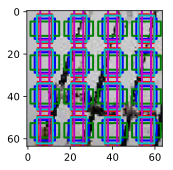

In [0]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize((3.5, 2.5))
    # The values from the first two dimensions will not affect the output
    fmap = nd.zeros((1, 10, fmap_w, fmap_h))
    anchors = contrib.nd.MultiBoxPrior(fmap, sizes=s, ratios=[1, 2, 0.5, 0.2, 0.6])
    bbox_scale = nd.array((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img.asnumpy()).axes,
                    anchors[0] * bbox_scale)
    
    
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

# 2. Single Shot Detector là gì?


![](https://i.imgur.com/LkrGKUh.png)

**Hình 2**: Cách thức phân chia feature map để nhận diện các hình ảnh với những kích thước khác nhau.

SSD chỉ cần duy nhất đầu vào là 1 bức ảnh và các ground truth boxes ám chỉ vị trí bounding box các vật thể trong suốt quá trình huấn luyện. Trong quá trình phát hiện vật thể, trên mỗi một feature map, chúng ta đánh giá các một tợp hợp nhỏ gồm những default boxes tương ứng với các tỷ lệ hướng khác nhau (aspect ratio) lên các features map có kích thước (scales) khác nhau (chẳng hạn kích thước 8x8 và 4x4 trong hình (b) và (c)). Đối với mỗi default box (các boxes nét đứt trong hình) ta cần dự báo một phân phối xác suất $\mathbf{c} = (c_1, c_2, ..., c_n)$ tương ứng với các class $C = \{C_1, C_2, ..., C_n\}$. Tại thời điểm huấn luyện, đầu tiên chúng ta cần match default boxes với ground truth boxes sao cho mức độ sai số được đo lường qua localization loss là nhỏ nhất (thường là hàm Smooth L1). Sau đó ta sẽ tìm cách tối thiểu hóa sai số của nhãn dự báo tương ứng với mỗi vật thể được phát hiện trong default boxes thông qua confidence loss (thường là hàm softmax).

Như vậy loss function của object detection sẽ khác với loss function của các tác vụ image classification ở chỗ có thêm localization loss về sai số vị trí của predicted boxes so với ground truth boxes.

Đó là nguyên lý hoạt động chung nhất của SSD. Tuy nhiên kiến trúc các layers và hàm loss function của SSD cụ thể là gì ta sẽ tìm hiểu biên dưới.

## 2.1. Kiến trúc của mô hình

![](https://i.imgur.com/QW2VHUI.png)

**Hình 3**: Sơ đồ kiến trúc của mạng SSD.

SSD dựa trên một tiến trình lan truyền thuận của một kiến trúc chuẩn (chẳng hạn VGG16) để tạo ra một khối feature map output gồm 3 chiều ở giai đoạn sớm. Chúng ta gọi kiến trúc mạng này là base network. Sau đó chúng ta sẽ thêm những kiến trúc phía sau base network để tiến hành nhận diện vật thể như trong sơ đồ. Các layers này được diễn giải đơn giản như sau:

* **Các layer của mô hình SSD**: 
  * Input Layer: Nhận input đầu vào là các bức ảnh có kích thước `(width x height x channels) = 300 x 300 x 3` đối với kiến trúc SSD300 hoặc `500 x 500 x 3` đối với kiến trúc SSD500.
  * Conv5_3 Layer: Chính là base network sử dụng kiến trúc của VGG16 nhưng loại bỏ một số layers fully connected ở cuối cùng. Output của layer này chính là Conv4_3 Layer và là một feature map có kích thước `38 x 38 x 512`.
  * Conv4_3 Layer: Ta có thể coi Conv4_3 là một feature map có kích thước `38 x 38 x 512`. Trên feature map này ta sẽ áp dụng 2 biến đổi chính đó là: Áp dụng một convolutional layer như một mạng CNN thông thường để thu được output layer tiếp theo. Cụ thể convolutional layer có convolutional kernel có kích thước `3 x 3 x 1024`, đầu ra thu được Conv6 có kích thước là `19 x 19 x 1024`.
  Đồng thời ở bước này ta cũng áp dụng một classifier (như trong sơ đồ) và cũng dựa trên convolutional filter kích thước `3 x 3` để nhằm nhận diện vật thể trên feature map. Đây là một quá trình khá phức tạp vì nó phải đảm bảo phát hiện vật thể (thông qua phát hiện bounding box) và phân loại vật thể. Quá trình này thực hiện tương tự như mô tả ở hình 2. Chẳng hạn như feature map của chúng ta là `38 x 38 x 512` thì sẽ cần chia nó thành một grid cell kích thước `38 x 38` (bỏ qua độ sâu vì ta sẽ thực hiện tích chập trên toàn bộ độ sâu).
  Sau đó mỗi một cell trên grid cell sẽ tạo ra 4 default bounding boxes với các tỷ lệ khung hình khác nhau (aspect ratio), mỗi một default bounding box ta cần tìm các tham số sau: phân phối xác suất của nhãn là một véc tơ có n_classes + 1 chiều (Lưu ý số lượng classes luôn cộng thêm 1 cho background). Đồng thời chúng ta cần thêm 4 tham số là offsets để xác định bounding box của vật thể trong khung hình. Do đó trên một default bounding box sẽ có n_classes + 4 tham số và trên 1 cell sẽ có 4*(n_classes+4) output cần dự báo. Nhân với số cells của Conv4_3 để thu được số lượng output là một tensor kích thước `38 x 38 x 4 x (n_classes+5)`, trong trường hợp coi background cũng là 1 nhãn thì tensor có kích thước `38 x 38 x 4 x (n_classes+4)`. Và số lượng các bounding box được sản sinh ra là `38 x 38 x 4`.
  
  * Qúa trình áp dụng classifier lên feature map cũng tương tự với các layer Conv7, Conv8_2, Conv_9, Conv10_2, Conv11_2. Shape của các layer sau sẽ phụ thuộc vào cách thức áp dụng mạng tích chập ở layer trước. Cụ thể ở đây là kernel_size áp dụng (như trong sơ đồ trên thì kernel_size luôn là `3 x 3`) và stride (độ lớn bước nhảy) của kernel_size.
  Số lượng các default boxes sản sinh ra ở các layers tiếp theo lần lượt như sau:
  * Conv7: 19×19×6 = 2166 boxes (6 boxes/cell)
  * Conv8_2: 10×10×6 = 600 boxes (6 boxes/cell)
  * Conv9_2: 5×5×6 = 150 boxes (6 boxes/cell)
  * Conv10_2: 3×3×4 = 36 boxes (4 boxes/cell)
  * Conv11_2: 1×1×4 = 4 boxes (4 boxes/cell)
  Tổng số lượng các boxes là: 5776 + 2166 + 600 + 150 + 36 +4 = 8732. Tức là chúng ta cần phải dự đoán class cho khoảng 8732 khung hình ở output. Số lượng này lớn hơn rất nhiều so với YOLO khi chỉ phải dự đoán chỉ 98 khung hình ở output. Các bạn có hình dung ra một khung hình được đại diện bởi những tham số nào không? Tôi xin nhắc lại đó là các tham số:
  
  $$y^{T} = [\underbrace{x, y, w, h}_{\text{bounding box}}, \underbrace{c_1, c_2,..., c_C}_{\text{scores of C classes}}]$$
  
* **Áp dụng các feature map với các kích thước khác nhau**: Sau khi thu được feature map base ở base network. Chúng ta sẽ tiếp tục thêm các convolutional layers. Những layers này sẽ nhằm giảm kích thước của feature map và cho phép dự báo và nhận diện vật thể ở nhiều kích thước khác nhau. Những feature map có kích thước lớn sẽ phát hiện tốt các vật thể nhỏ và các feature map kích thước nhỏ giúp phát hiện tốt hơn các vật thể lớn. Cụ thể hơn về kích thước kernel filters sẽ xem ở sơ đồ kiến trúc trong phần Extra Features Layers.

* **Dự báo thông qua mạng tích chập đối với object**: Mỗi một feature layer thêm vào ở Extra Features Layers sẽ tạo ra một tợp hợp cố định các nhận diện dự báo (detection prediction) khác nhau nhờ sử dụng một tợp hợp các kernel filters với đa dạng các kích thước. Kích thước ở đầu ra (`with x height x chanel`) ở mỗi loại kích thước feature layer sẽ phụ thuộc vào kernal filters và được tính toán hoàn toàn tương tự như đối với mạng neural tích chập thông thường. Xem thêm mục 1. lý thuyết về mạng tích chập trong [Giới thiệu mạng neural tích chập](https://www.kaggle.com/phamdinhkhanh/convolutional-neural-network) để hiểu tích chập được tính như thế nào và output shape là bao nhiêu.

* **Default box và tỷ lệ hướng (aspect ratio)**: Chúng ta cần liên kết một tợp hợp default bounding boxes với mỗi một cell trên feature map, thực hiện tương tự cho các features map khác ở cuối của network. Các default boxes sẽ chạy lát gạch trên feature map theo thứ tự từ trên xuống dưới và từ trái qua phải để tính tích chập, do đó vị trí của mỗi default box tương ứng với cell mà nó liên kết là cố định tương đối trên bức ảnh. Tại mỗi một ô của feature map chúng ta dự báo 4 offsets tương ứng với một kích thước default box. 4 offsets ở đây được hiểu là một tọa độ gồm 4 tham số $(c_x, c_y, w, h)$. Trong đó $(c_x, c_y)$ giúp xác định tâm và $(w, h)$ là kích thước dài rộng của bounding box. Thành phần thứ 2 được dự báo là điểm số của bounding box tương ứng với mỗi class. Lưu ý ta sẽ có thêm một class thứ $C+1$ để đánh dấu trường hợp default bounding box không có vật thể (hoặc rơi vào background).

  * Ví dụ đối với một feature map có kích thước `m x n` tương ứng với `p` channels (chẳng hạn như kích thước 8 x 8 hoặc 4 x 4), một kernel filter kích thước `3 x 3 x p` sẽ được áp dụng trên toàn bộ feature layer. 
  * Các giá trị trong kernel này chính là các tham số của mô hình và được tinh chỉnh trong quá trình training. 
  * Các kernel filter sẽ dự đoán đồng thời **Xác suất nhãn** và **kích thước offset** tương ứng với tọa độ của default box. 
  * Với mỗi location (hoặc cell) nằm trên feature map ta sẽ liên kết nó với $k$ bounding boxes. Các boxes này có kích thước khác nhau và tỷ lệ hướng khác nhau.
  * Với mỗi một bounding box, chúng ta tính được phân phối điểm của $C$ classes là $c = (c_1, c_2, ... ,c_C)$ và 4 offsets tương ứng với kích thước ban đầu của default bounding box.
  * Kết quả cuối cùng ta thu được $(C+4)\times mnk$ outputs.
  
  Các default box của chúng ta tương tự như anchor boxes trong mạng faster R-CNN nhưng được áp dụng trên một vài feature maps với những độ phân giải khác nhau. Điều này cho phép các default bounding box phân biệt hiệu quả kích thước vật thể khác nhau.
  
Kết thúc phần này chúng ta đã hiểu được kiến trúc các layer của mạng SSD. Tuy nhiên quá trình huấn luyện và hàm loss function của SSD vẫn còn là một điều bí ẩn. Liệu hàm loss function của SSD có gì khác so với các thuật toán Image classification? Quá trình tối ưu cần xét đến những mất mát nào? Hãy tìm  hiểu ở phần tiếp theo.



## 2.2. Qúa trình huấn luyện

**Chiến lược mapping default box** Trong suốt quá trình huấn luyện ta cần mapping các default boxes có tỷ lệ aspect ratio khác nhau với ground truth box. Để mapping được chúng với nhau ta cần đo lường chỉ số IoU (Intersection of Union) hoặc chỉ số [Jaccard overlap index](https://en.wikipedia.org/wiki/Jaccard_index) được dùng để đo lường tỷ lệ diện tích giao nhau giữa 2 vùng hình ảnh so với tổng diện tích (không tính phần giao nhau) của chúng. Chúng ta sẽ match các default boxes với bất kì ground truth nào có threshold > 0.5. 

Như chúng ta đã biết trên mỗi cell chúng ta chỉ qui định một số lượng nhất định (4 hoặc 6, tùy từng feature map) các default bounding box. Vậy các default bounding box này được xác định trước thông qua aspect ratio và scale hay ngẫu nhiên? Trên thực tế là chúng hầu hết được xác định từ trước để giảm thiểu số lượng khung hình/cell cần dự báo. Tợp hợp các khung hình được xác định ra phải đảm bảo sao cho mỗi một ground truth bất kì đều có thể tìm được một default bounding box gần nó nhất. Do đó một thuật toán K-mean clustering được thực hiện trên aspect ratio của mỗi ground truth image nhằm phân cụm các khung hình trên thực tế. Tâm của các clusters (còn gọi là centroids) sẽ được dùng làm các giá trị aspect ratio đại diện để tính default bounding box. Tôi hi vọng các bạn hiểu những gì tôi vừa trình bày? Không quá phức tạp phải không?

**Huấn luyện để tìm ra object**: Việc dự báo các object sẽ được thực hiện trên tợp hợp các khung hình output của mạng SSD. Đặt $x_{ij}^k = \{0, 1\}$ là chỉ số đánh giá cho việc matching giữa default bounding box thứ $i$ với ground truth box thứ $j$ đối với nhãn thứ $k$. Trong quá trình mapping chúng ta có thể có nhiều bounding box được map vào cùng 1 ground truth box với cùng 1 nhãn dự báo nên tổng $\sum_{i}x_{ij}^k \geq 1$. Hàm loss function là tổng có trọng số của localization loss (loc) và confidence loss (conf):

$$L(x, c, p, g) = \frac{1}{N}(L_{conf}(x, c) + \alpha L_{loc}(x, p, g)) \tag{1}$$

Trong đó $N$ là số lượng các default boxes matching với ground truth boxes. Ta nhận thấy giá trị của hàm loss function của SSD hoàn toàn giống với faster R-CNN và bao gồm 2 thành phần:

1. **localization loss** là một hàm Smooth L1 đo lường sai số giữa tham số của box dự báo (predicted box) ($p$) và ground truth box ($g$) như bên dưới:. Chúng ta sẽ cần hồi qui các offsets cho tâm $(x, y)$ và của default bounding box ($d$) và các chiều dài $h$ và chiều rộng $w$.
$$L_{loc}(x, p ,g) = \sum_{i \in Pos}^{N}\sum_{m \in \{x, y, w, h\}} x^{k}_{ij} \space L_1^\text{smooth}(p_i^m - \hat{g}_j^m)$$
Như vậy Localization loss chỉ xét trên các positive matching ($i \in Pos$) giữa predicted bounding box với ground truth bounding box. Nếu $IoU > 0.5$ thì được coi là positive matching (tức predicted bounding box chứa vật thể). Trái lại, nếu $IoU <= 0.5$ ta không cần quan tâm và coi như xóa các predicted bounding box này khỏi hình ảnh. Thành phần $\sum_{m \in \{x, y, w, h\}} x^{k}_{ij} \space L_1^\text{smooth}(p_i^m - \hat{g}_j^m)$ chính là tổng khoảng cách giữa predicted box ($p$) và ground truth box ($g$) trên 4 offsets $\{x, y, w, h\}$.

Nếu để nguyên các giá trị tọa độ tâm và kích thước $(w, h)$ của khung hình sẽ rất khó để xác định sai số một cách chuẩn xá. Cụ thể ta hãy so sánh sai số trong trường hợp khung hình lớn và khung hình bé. Trong trường hợp khung hình lớn có predicted box và ground truth box rất khớp nhau. Tuy nhiên do khung hình quá to nên khoảng cách tâm của chúng sẽ lớn một chút, giả định là aspect ratio của chúng bằng nhau. Còn trường hợp khung hình bé, sai số của tâm giữa predicted box và ground truth box có thể bé hơn trường hợp khung hình lớn về số tuyệt đối. Nhưng điều đó không có nghĩa rằng predicted box và ground truth box của khung hình bé là rất khớp nhau. Chúng có thể cách nhau rất xa.

Do đó chúng ta cần phải chuẩn hóa kích thước width, height và tâm sao cho không có sự khác biệt trong trường hợp khung hình bé và lớn. Một phép chuẩn hóa các offset được thực hiện nhưa sau:

Các tham số $\hat{g}^m$ được tính thông qua đo lường chênh lệch khoảng cách tâm và mức độ thay đổi kích thước (scale) dài và rộng giữa lần lượt ground truth box so với default box. Để hiều rõ hơn cách tính $\hat{g}^m$ như thế nào ta xem hình minh họa đối với tính $\hat{g}^{m}$ như bên dưới:
![Transform predict box to ground truth box](https://imgur.com/ntyb7BW.png)

> **Hình 4:** Hình chữ nhận viền đen đại diện cho ground truth box và hình chữ nhật viền đỏ đại diện cho default bounding box. $(d_w, d_h)$ lần lượt là kích thước dài rộng và $(d_x, d_y)$ là tọa độ tâm của default bounding box. Khi đó để chuyển từ tâm của default bounding box sang tâm của ground truth box ta cần 1 phép dịch chuyển tuyến tính các khoảng $(d_wt_x, d_ht_y)$. Kích thước các chiều dài và rộng được scale so với default bounding box số lần $(e^{t_h}, e^{t_w})$.

  * Khoảng cách tâm $(p_x, p_y)$ của predicted box so với tâm $(d_x, d_y)$ của default box:
$$\hat{g}_x = \frac{g_x-d_x}{d_w} \triangleq t_{x}$$
$$\hat{g}_y = \frac{g_y-d_y}{d_h} \triangleq t_{y}$$

  * Độ scale theo chiều dài và rộng $(p_w, p_h)$ của predicted box so với chiều dài và rộng $(d_w, d_h)$ của ground truth box:
$$\hat{g}_w = log(\frac{d_w}{g_w}) \triangleq t_{w}$$
$$\hat{g}_h = log(\frac{d_h}{g_h}) \triangleq t_{h}$$
Kí hiệu $\triangleq$ nghĩa là đặt vế trái bằng vế phải.
Ta nhận thấy các giá trị $t_{x}, t_{y}, t_w, t_h$ là những tham số tinh chỉnh kích thước của bounding box nhận giá trị trong khoảng từ $(-\infty, +\infty)$. Nếu các giá trị của $t_x, t_y$ càng lớn thì khoảng cách giữa 2 tâm ground truth box và default box càng lớn. 

Gía trị của $t_w, t_h$ càng lớn, tỷ lệ chêch lệch kích thước dài rộng giữa ground truth box và default box càng lớn. Ta gọi giá trị bộ tham số $(t_x, t_y, t_w, t_h)$ là bộ tham số kích thước chuẩn hóa của ground truth box theo default box. Tương tự ta cũng tính được bộ tham số kích thước chuẩn hóa của predicted box theo default box bằng cách thế $g_m$ bằng $p_m$ với $m \in \{x, y, w, h\}$ trong những phương trình trên. Để hiểu hơn về các tham số chuẩn hóa có thể xem [Faster R-CNN - Mục A Loss Function for Learning Region Proposals](https://papers.nips.cc/paper/5638-faster-r-cnn-towards-real-time-object-detection-with-region-proposal-networks.pdf). Khi đó khoảng cách giữa predicted box và ground truth box sẽ càng gần nếu khoảng cách giữa các bộ tham số chuẩn hóa giữa chúng càng gần. Tức khoảng cách giữa 2 véc tơ $p$ và $\hat{g}$ càng nhỏ càng tốt.

Khoảng cách này được đo lường thông qua hàm $L_1^\text{smooth}$ là một kết hợp giữa norm chuẩn bậc 1 (đối với các giá trị tuyệt đối của $x$ lớn) và norm chuẩn bậc 2 (đối với các giá trị tuyệt đối của $x$ nhỏ) theo công thức sau:
$$L_1^\text{smooth}(x) = \begin{cases}
    0.5 x^2             & \text{if } \vert x \vert < 1\\
    \vert x \vert - 0.5 & \text{otherwise}
\end{cases}$$
Trong trường hợp $x$ là một véc tơ thì thay $x$ ở vế phải bằng giá trị norm chuẩn bậc 1 của $x$ kí hiệu là $|x|$. Việc lựa chọn hàm loss function là smooth L1 là để giá trị của đạo hàm gradient descent cố định khi $|x|$ lớn và smoothing khi $x$ nhỏ. Về norm chuẩn các bạn có thể xem trong bài tổng hợp [ML appendix](https://www.kaggle.com/phamdinhkhanh/ml-appendix). 
Trong phương trình của hàm localization loss thì các hằng số mà ta đã biết chính là $\hat{g}$. Biến cần tìm giá trị tối ưu chính là $p$. Sau khi tìm ra được nghiệm tối ưu của $p$ ta sẽ tính ra predicted box nhờ phép chuyển đổi từ default box tương ứng.


2. **confidence loss** là một hàm mất mát được tính toán dựa trên sai số dự báo nhãn. Đối với mỗi một positive match prediction, chúng ta phạt loss function theo confidence score của các nhãn tương ứng. Đối với mỗi một negative match prediction, chúng ta phạt loss function theo confidence score của nhãn '0' là nhãn đại diện cho background không chứa vật thể. Cụ thể hàm confidence loss như bên dưới:
$$L_{conf}(x, c) = -\sum_{i \in Pos} x_{ij}^{k}*log(\hat{c}_{i}^k) - \sum_{i \in Neg}log(\hat{c}_{i}^0)$$
Trong trường hợp positive match prediction thì vùng được dự báo có vật thể chính xác là chứa vật thể. Do đó việc dự báo nhãn cho nó sẽ tương tự như một bài toán classification với hàm softmax thông thường có dạng $-\sum_{i \in Pos} x_{ij}^{k}*log(\hat{c}_{i}^p)$. Trong trường hợp negative match prediction tức vùng được dự báo là không chứa vật thể chúng ta sẽ chỉ có duy nhất một nhãn là 0. Và tất nhiên ta đã biết trước bounding box là không chứa vật thể nên xác xuất để xảy ra nhóm 0 là $x_{ij}^{0} = 1$. Do đó hàm softmax có dạng $- \sum_{i \in Neg}log(\hat{c}_{i}^0)$.


Hàm loss function cuối cùng được tính là tổng của 2 confidence loss và localization loss như (1).

**Lựa chọn kích cỡ (scales) và tỷ lệ hướng (aspect ratio):** 

Các default boundary box được lựa chọn thông qua aspect ratio và scales. SSD sẽ xác định một tỷ lệ scale tương ứng với mỗi một features map trong Extra Feature Layers. Bắt đầu từ bên trái, Conv4_3 phát hiện các object tại các scale nhỏ nhất là $s_{min} = 0.2$ (đôi khi là 0.1) và sau đó gia tăng tuyến tính để layer cuối cùng ở phía bên phải có scale là $s_{max} = 0.9$ theo công thức:

$$s_k = s_{min} + \frac{s_{max} - s_{min}}{m-1}(k-1), k \in [1,m]$$

Với $k$ là số thứ tự của layers. Kết hợp giữa giá trị scale với aspect ratio chúng ta sẽ tính được width và height của default boxes. Với các layers có 6 dự báo, SSD sẽ tạo ra 5 default boxes với các aspect ratios lần lượt là: 1, 2, 3, 1/2, 1/3. Sau đó width và height của default boxes được tính theo công thức:

$$w = scale * \sqrt{\text{aspect ratio}}$$

$$h = \frac{scale}{\sqrt{\text{aspect ratio}}}$$

Trong trường hợp aspect ratio = 1 thì ta sẽ thêm một default bounding box thứ 6 với scale được tính theo công thức:

$$s_k' = \sqrt{s_ks_{k+1}}$$

# 3. Code

Thuật toán SDD là một thuật toán rất phức tạp, có nhiều layers và các phases xử lý khác nhau. Tất nhiên code bên dưới là tôi tham khảo từ những nhà nghiên cứu xuất sắc trên thế giới. Đối với các kiến thức tôi trình bày ở các bài viết của mình cũng như vậy. Tôi cũng không phủ nhận đó là những kiến thức tổng hợp từ nhiều nguồn bởi không ai có thể nghĩ ra tất cả. Và tôi cũng nhận được một số lời chỉ trích là [cop nhặt](https://www.facebook.com/groups/machinelearningcoban/?multi_permalinks=778367739287302). Nhưng điều đó không làm tôi dừng lại bởi tôi nghĩ rằng việc học một kiến thức mới và viết lại theo cách hiểu của mình là hữu ích để lưu lại kiến thức cho mình. Và sẽ hữu ích hơn khi chia sẻ những kiến thức, những giá trị mà thuộc về của chung ấy cho mọi người. Vừa tốt cho tôi vừa đóng góp cho cộng đồng. Tôi tin rằng những lời chỉ trích chỉ là số rất nhỏ trong những sự động viên ủng hộ và đó là động lực để tôi tiếp tục viết bài. Sau tất cả, trên hết tôi luôn tôn trọng bản quyền các bài viết gốc mà tôi đã đọc và để trích dẫn trong mục tham khảo.

Xin lỗi các bạn vì hơi lan man chút. Quay trở lại phần code mình họa cho thuật toán SSD được lấy từ nguồn [SSD_keras - git repository](https://github.com/pierluigiferrari/ssd_keras). Trong git project tác giả cũng hướng dẫn khá chi tiết cách thức vận hành. Tôi có đọc tham khảo và trích dẫn một số phần xử lý minh họa cho thuật toán.

In [0]:
# Mount folder
import os
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/ssd_keras/ssd_keras-master'
os.chdir(path)
os.listdir()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


['.gitattributes',
 '.github',
 '.gitignore',
 'CONTRIBUTING.md',
 'ISSUE_TEMPLATE.md',
 'LICENSE.txt',
 'README.md',
 '__init__.py',
 'bounding_box_utils',
 'data_generator',
 'eval_utils',
 'examples',
 'keras_layers',
 'keras_loss_function',
 'misc_utils',
 'models',
 'ssd300_evaluation.ipynb',
 'ssd300_inference.ipynb',
 'ssd512_inference.ipynb',
 'ssd7_training.ipynb',
 'ssd_encoder_decoder',
 'training_summaries',
 'weight_sampling_tutorial.ipynb',
 'ssd300_evaluation_COCO.ipynb',
 'pretrain_model',
 'ssd300_training.ipynb']

## 3.1. Keras Layers
## 3.1.2. Anchor Box

Phần tinh túy nhất của SSD có lẽ là việc xác định các layers output của anchor box (hoặc default bounding box) ở các feature map. anchor box layer sẽ nhận đầu vào ra một feature map có kích thước `(feature_width, feature_height, n_channels)` và các scales, aspect ratios, trả ra đầu ra là một tensor kích thước `(feature_width, feature_height, n_boxes, 4)`, trong đó chiều cuối cùng đại diện cho 4 offsets của bounding box như mô tả trong **Default box và tỷ lệ hướng (aspect ratio)** của mục 2.1.

Code biến đổi khá phức tạp. Tôi trong đó các phần biến đổi chính được thực hiện trong hàm `call()`.

* **Bước 1**: Từ scale, size (giá trị lớn nhất của with và height), và aspect ratio ta xác định kích thước các cạnh của các bounding box theo công thức:
$$\begin{cases}
\textit{box_h} = \textit{scale * size} /
\sqrt{\textit{aspect ratio}}\\
\textit{box_w} = \textit{scale * size} * \sqrt{\textit{aspect ratio}}
\end{cases}$$
* **Bước 2**: Từ các cell trên feature map chiếu lại trên ảnh input image để thu được step khoảng cách giữa các center point của mỗi cell theo công thức:

$$\begin{cases}
\textit{step_h} = \textit{img_h} /
\textit{feature_map_h}\\
\textit{step_w} = \textit{img_w} / \textit{feature_map_w}
\end{cases}$$

* **Bước 3**: Tính tọa độ các điểm $(c_x, c_y, w, h)$ trên hình ảnh gốc dựa trên phép linear interpolation qua hàm [np.linspace()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html).
$$\begin{cases}
   c_x = \textit{np.linspace(start_w, end_w, feature_map_w)}\\
    c_y = \textit{np.linspace(start_h, end_h, feature_map_h)}
\end{cases}$$
Kết quả trả về là một tensor có shape là `(feature_width, feature_height, n_boxes, 4)`, trong đó chiếu cuối cùng = 4 tương ứng với các offsets của default bounding box.

In [0]:
from __future__ import division
import numpy as np
import keras.backend as K
from keras.engine.topology import InputSpec
from keras.engine.topology import Layer

from bounding_box_utils.bounding_box_utils import convert_coordinates

class AnchorBoxes(Layer):
    '''
    Tác dụng: Tạo ra một output tensor chứa tọa độ của các anchor box và các biến thể dựa trên input tensor.
    Một tợp hợp các 2D anchor boxes được tạo ra dựa trên aspect ratios và scale trên mỗi một cells của grid cells. Các hộp được tham số hóa bằng các tọa độ `(xmin, xmax, ymin, ymax)`
    
    Input shape:
        4D tensor shape `(batch, channels, height, width)` nếu `dim_ordering = 'th'`
        or `(batch, height, width, channels)` nếu `dim_ordering = 'tf'`.

    Output shape:
        5D tensor of shape `(batch, height, width, n_boxes, 8)`. 
        Chiều cuối cùng gồm 4 tọa độ của anchor box và 4 giá trị biến thể ở mỗi box.
    '''

    def __init__(self,
                 img_height,
                 img_width,
                 this_scale,
                 next_scale,
                 aspect_ratios=[0.5, 1.0, 2.0],
                 two_boxes_for_ar1=True,
                 this_steps=None,
                 this_offsets=None,
                 clip_boxes=False,
                 variances=[0.1, 0.1, 0.2, 0.2],
                 coords='centroids',
                 normalize_coords=False,
                 **kwargs):
        '''

        Arguments:
            img_height (int): chiều cao input images.
            img_width (int): chiều rộng input images.
            this_scale (float): một giá trị float thuộc [0, 1], nhân tố scaling kích thước để tạo các anchor boxes dựa trên một tỷ lệ so với cạnh ngắn hơn trong width và height.
            next_scale (float): giá trị tiếp theo của scale. Được thiết lập khi vào chỉ khi
                `self.two_boxes_for_ar1 == True`.
            aspect_ratios (list, optional): tợp hợp các aspect ratios của các default boxes được tạo ra từ layer này.
            two_boxes_for_ar1 (bool, optional): Được sử dụng chỉ khi `aspect_ratios` = 1.
                Nếu `True`, hai default boxes được tạo ra khi aspect ratio = 1. default box đầu tiên sử dụng scaling factor của layer tương ứng,
                default box thứ 2 sử dụng trung bình hình học giữa scaling factor và next scaling factor.
            clip_boxes (bool, optional): Nếu đúng `True`, giới hạn tọa độ anchor box nằm bên trong hình ảnh.
            variances (list, optional): Tợp hợp gồm 4 giá trị floats > 0. Là các anchor box offset tương ứng với mỗi tọa độ chia cho giá trị variances tương ứng của nó.
            coords (str, optional): Tọa độ của box được sử dụng trong model. Có thể là centroids định dạng `(cx, cy, w, h)` (tọa độ box center, width, height),
                hoặc 'corners' định dạng `(xmin, ymin, xmax,  ymax)`, hoặc 'minmax' định dạng `(xmin, xmax, ymin, ymax)`.
            normalize_coords (bool, optional): Nếu `True` mô hình sử dụng tọa độ tương đối thay vì tuyệt đối. Chẳng hạn mô hình dự đoán tọa độ nằm trong [0, 1] thay vì tọa độ tuyệt đối.
        '''
        if K.backend() != 'tensorflow':
            raise TypeError("This layer only supports TensorFlow at the moment, but you are using the {} backend.".format(K.backend()))

        if (this_scale < 0) or (next_scale < 0) or (this_scale > 1):
            raise ValueError("`this_scale` must be in [0, 1] and `next_scale` must be >0, but `this_scale` == {}, `next_scale` == {}".format(this_scale, next_scale))

        if len(variances) != 4:
            raise ValueError("4 variance values must be pased, but {} values were received.".format(len(variances)))
        variances = np.array(variances)
        if np.any(variances <= 0):
            raise ValueError("All variances must be >0, but the variances given are {}".format(variances))

        self.img_height = img_height
        self.img_width = img_width
        self.this_scale = this_scale
        self.next_scale = next_scale
        self.aspect_ratios = aspect_ratios
        self.two_boxes_for_ar1 = two_boxes_for_ar1
        self.this_steps = this_steps
        self.this_offsets = this_offsets
        self.clip_boxes = clip_boxes
        self.variances = variances
        self.coords = coords
        self.normalize_coords = normalize_coords
        # Tính toán số lượng boxes trên 1 cell. TH aspect ratios = 1 thì thêm 1 box.
        if (1 in aspect_ratios) and two_boxes_for_ar1:
            self.n_boxes = len(aspect_ratios) + 1
        else:
            self.n_boxes = len(aspect_ratios)
        super(AnchorBoxes, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(AnchorBoxes, self).build(input_shape)

    def call(self, x, mask=None):
        '''
        Return: Trả về 1 anchor box tensor dựa trên shape của input tensor.

        Tensor này được thiết kế như là hằng số và không tham gia vào quá trình tính toán.

        Arguments:
            x (tensor): 4D tensor có shape `(batch, channels, height, width)` nếu `dim_ordering = 'th'`
                hoặc `(batch, height, width, channels)` nếu `dim_ordering = 'tf'`. Input cho layer này phải là output của các localization predictor layer.
        '''
        #####################################################
        # Bước 1: Tính toán with và heigth của box với mỗi aspect ratio
        #####################################################
        # Cạnh ngẵn hơn của hình ảnh có thể được sử dụng để tính `w` và `h` sử dụng `scale` và `aspect_ratios`.
        size = min(self.img_height, self.img_width)
        # Tính toán box widths và heights cho toàn bộ aspect ratios
        wh_list = []
        for ar in self.aspect_ratios:
            if (ar == 1):
                # Tính anchor box thông thường khi aspect ratio = 1.
                box_height = box_width = self.this_scale * size
                wh_list.append((box_width, box_height))
                if self.two_boxes_for_ar1:
                    # Tính version lớn hơn của anchor box sử dụng the geometric mean của scale và next scale.
                    box_height = box_width = np.sqrt(self.this_scale * self.next_scale) * size
                    wh_list.append((box_width, box_height))
            else:
                # Trường hợp còn lại box_height = scale/sqrt(aspect ratio); box_width = scale*sqrt(aspect ratio)
                box_height = self.this_scale * size // np.sqrt(ar)
                box_width = int(self.this_scale * size * np.sqrt(ar))
                wh_list.append((box_width, box_height))
        # append vào width height list
        wh_list = np.array(wh_list)

        # Định hình input shape 
        if K.common.image_dim_ordering() == 'tf':
            batch_size, feature_map_height, feature_map_width, feature_map_channels = x.get_shape().as_list()
        else:
            batch_size, feature_map_channels, feature_map_height, feature_map_width = x.get_shape().as_list()
        
        # Tính các center points của grid of box. Chúng là duy nhất đối với các aspect ratios.
        #####################################################
        # Bước 2: Tính các step size. Khoảng cách là bao xa giữa các anchor box center point theo chiều width và height.
        #####################################################
        if (self.this_steps is None):
            step_height = self.img_height // feature_map_height
            step_width = self.img_width // feature_map_width
        else:
            if isinstance(self.this_steps, (list, tuple)) and (len(self.this_steps) == 2):
                step_height = self.this_steps[0]
                step_width = self.this_steps[1]
            elif isinstance(self.this_steps, (int, float)):
                step_height = self.this_steps
                step_width = self.this_steps
        # Tính toán các offsets cho anchor box center point đầu tiên từ góc trên cùng bên trái của hình ảnh.
        if (self.this_offsets is None):
            offset_height = 0.5
            offset_width = 0.5
        else:
            if isinstance(self.this_offsets, (list, tuple)) and (len(self.this_offsets) == 2):
                offset_height = self.this_offsets[0]
                offset_width = self.this_offsets[1]
            elif isinstance(self.this_offsets, (int, float)):
                offset_height = self.this_offsets
                offset_width = self.this_offsets
        #####################################################
        # Bước 3: Tính toán các tọa độ của (cx, cy, w, h) theo tọa độ của image gốc.
        #####################################################
        # Bây h chúng ta có các offsets và step sizes, tính grid của anchor box center points.
        cy = np.linspace(offset_height * step_height, (offset_height + feature_map_height - 1) * step_height, feature_map_height)
        cx = np.linspace(offset_width * step_width, (offset_width + feature_map_width - 1) * step_width, feature_map_width)
        cx_grid, cy_grid = np.meshgrid(cx, cy)
        cx_grid = np.expand_dims(cx_grid, -1) 
        cy_grid = np.expand_dims(cy_grid, -1) 
        

        # Tạo một 4D tensor có shape `(feature_map_height, feature_map_width, n_boxes, 4)`
        # Chiều cuối cùng sẽ chứa `(cx, cy, w, h)`
        boxes_tensor = np.zeros((feature_map_height, feature_map_width, self.n_boxes, 4))

        boxes_tensor[:, :, :, 0] = np.tile(cx_grid, (1, 1, self.n_boxes)) # đặt cx
        boxes_tensor[:, :, :, 1] = np.tile(cy_grid, (1, 1, self.n_boxes)) # đặt cy
        boxes_tensor[:, :, :, 2] = wh_list[:, 0] # đặt w
        boxes_tensor[:, :, :, 3] = wh_list[:, 1] # đặt h
        
        # Chuyển `(cx, cy, w, h)` sang `(xmin, xmax, ymin, ymax)`
        boxes_tensor = convert_coordinates(boxes_tensor, start_index=0, conversion='centroids2corners')

        # Nếu `clip_boxes` = True, giới hạn các tọa độ nằm trên boundary của hình ảnh
        if self.clip_boxes:
            x_coords = boxes_tensor[:,:,:,[0, 2]]
            x_coords[x_coords >= self.img_width] = self.img_width - 1
            x_coords[x_coords < 0] = 0
            boxes_tensor[:,:,:,[0, 2]] = x_coords
            y_coords = boxes_tensor[:,:,:,[1, 3]]
            y_coords[y_coords >= self.img_height] = self.img_height - 1
            y_coords[y_coords < 0] = 0
            boxes_tensor[:,:,:,[1, 3]] = y_coords

        # Nếu `normalize_coords` = True, chuẩn hóa các tọa độ nằm trong khoảng [0,1]
        if self.normalize_coords:
            boxes_tensor[:, :, :, [0, 2]] /= self.img_width
            boxes_tensor[:, :, :, [1, 3]] /= self.img_height

        if self.coords == 'centroids':
            # Convert `(xmin, ymin, xmax, ymax)` to `(cx, cy, w, h)`.
            boxes_tensor = convert_coordinates(boxes_tensor, start_index=0, conversion='corners2centroids', border_pixels='half')
        elif self.coords == 'minmax':
            # Convert `(xmin, ymin, xmax, ymax)` to `(xmin, xmax, ymin, ymax).
            boxes_tensor = convert_coordinates(boxes_tensor, start_index=0, conversion='corners2minmax', border_pixels='half')

        # Tạo một tensor chứa các variances và append vào `boxes_tensor`. 
        variances_tensor = np.zeros_like(boxes_tensor) # shape `(feature_map_height, feature_map_width, n_boxes, 4)`
        variances_tensor += self.variances # Mở rộng thêm variances
        # Bây h `boxes_tensor` trở thành tensor kích thước `(feature_map_height, feature_map_width, n_boxes, 8)`
        boxes_tensor = np.concatenate((boxes_tensor, variances_tensor), axis=-1)

        # Bây h chuẩn bị trước một chiều cho `boxes_tensor` đại diện cho batch size và di chuyển copy theo chiều đó (theo kiểu lợp ngói, xem thêm np.tile)
        #  ta được một 5D tensor kích thước `(batch_size, feature_map_height, feature_map_width, n_boxes, 8)`
        boxes_tensor = np.expand_dims(boxes_tensor, axis=0)
        boxes_tensor = K.tile(K.constant(boxes_tensor, dtype='float32'), (K.shape(x)[0], 1, 1, 1, 1))

        return boxes_tensor

    def compute_output_shape(self, input_shape):
        if K.common.image_dim_ordering() == 'tf':
            batch_size, feature_map_height, feature_map_width, feature_map_channels = input_shape
        else: 
            batch_size, feature_map_channels, feature_map_height, feature_map_width = input_shape
        return (batch_size, feature_map_height, feature_map_width, self.n_boxes, 8)

    def get_config(self):
        config = {
            'img_height': self.img_height,
            'img_width': self.img_width,
            'this_scale': self.this_scale,
            'next_scale': self.next_scale,
            'aspect_ratios': list(self.aspect_ratios),
            'two_boxes_for_ar1': self.two_boxes_for_ar1,
            'clip_boxes': self.clip_boxes,
            'variances': list(self.variances),
            'coords': self.coords,
            'normalize_coords': self.normalize_coords
        }
        base_config = super(AnchorBoxes, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Using TensorFlow backend.


In [0]:
# Test output of Anchor box
import tensorflow as tf
x = tf.random.normal(shape = (4, 38, 38, 512))

aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                         [1.0, 2.0, 0.5],
                         [1.0, 2.0, 0.5]]
two_boxes_for_ar1=True
steps=[8, 16, 32, 64, 100, 300]
offsets=None
clip_boxes=False
variances=[0.1, 0.1, 0.2, 0.2]
coords='centroids'
normalize_coords=True
subtract_mean=[123, 117, 104]
divide_by_stddev=None
swap_channels=[2, 1, 0]
confidence_thresh=0.01
iou_threshold=0.45
top_k=200
nms_max_output_size=400


# Thiết lập tham số
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True


anchors = AnchorBoxes(img_height, img_width, this_scale=scales[1], next_scale=scales[2])(x)
print('anchors shape: ', anchors.get_shape())


anchors shape:  (4, 38, 38, 4, 8)


## L2Normalization

In [0]:
from __future__ import division
import numpy as np
import keras.backend as K
from keras.engine.topology import InputSpec
from keras.engine.topology import Layer

class L2Normalization(Layer):
    '''
    Performs L2 normalization on the input tensor with a learnable scaling parameter
    as described in the paper "Parsenet: Looking Wider to See Better" (see references)
    and as used in the original SSD model.

    Arguments:
        gamma_init (int): The initial scaling parameter. Defaults to 20 following the
            SSD paper.

    Input shape:
        4D tensor of shape `(batch, channels, height, width)` if `dim_ordering = 'th'`
        or `(batch, height, width, channels)` if `dim_ordering = 'tf'`.

    Returns:
        The scaled tensor. Same shape as the input tensor.

    References:
        http://cs.unc.edu/~wliu/papers/parsenet.pdf
    '''

    def __init__(self, gamma_init=20, **kwargs):
        if K.common.image_dim_ordering() == 'tf':
            self.axis = 3
        else:
            self.axis = 1
        self.gamma_init = gamma_init
        super(L2Normalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        gamma = self.gamma_init * np.ones((input_shape[self.axis],))
        self.gamma = K.variable(gamma, name='{}_gamma'.format(self.name))
        self.trainable_weights = [self.gamma]
        super(L2Normalization, self).build(input_shape)

    def call(self, x, mask=None):
        output = K.l2_normalize(x, self.axis)
        return output * self.gamma

    def get_config(self):
        config = {
            'gamma_init': self.gamma_init
        }
        base_config = super(L2Normalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

import tensorflow as tf
x = tf.random.normal(shape = (4, 38, 38, 512))
conv4_3 = L2Normalization(gamma_init=20, name='conv4_3_norm')(x)
print(conv4_3.get_shape())

(4, 38, 38, 512)


### 3.1.2. Model

Các bước thực hiện để khởi tạo cấu trúc của mạng ssd_300 bao gồm:
* **Bước 1**: Xây dựng kiến trúc mạng bao gồm:
  * Bước 1.1: Xây dựng kiến trúc mạng base network theo VGG16 đã loại bỏ các fully connected layers ở cuối.
  * Bước 1.2: Áp dụng các convolutional filter có kích thước `(3 x 3)` để tính toán ra features map.
  * Bước 1.3: Xác định output phân phối xác suất theo các classes ứng với mỗi một default bounding box.
  * Bước 1.4: Xác định output các tham số offset của default bounding boxes tương ứng với mỗi cell trên các features map.
  * Bước 1.5: Bước 1.5: Tính toán các AnchorBoxes làm cơ sở để dự báo offsets cho các predicted bounding boxes bao quan vật thể. Gía trị của các AnchorBoxes chỉ hỗ trợ trong quá trình tính toán offsets và không xuất hiện ở output như giá trị cần dự báo.
* **Bước 2**: Reshape lại các output để đưa chúng về kích thước của `(feature_map_w, feature_map_h, n_boxes, -1)`. Trong đó -1 đại diện cho chiều cuối cùng được tính dựa vào các chiều còn lại theo hàm reshape.
* **Bước 3**: Liên kết các khối tensorflow output của bước 2 được tính từ confidence, các offsets của bounding box và các offsets của anchor box.
* **Bước 4**: Kết nối với output. Thêm layers softmax trước confidence của bounding box.

In [0]:
from __future__ import division
import numpy as np
from keras.models import Model
from keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Reshape, Concatenate
from keras.regularizers import l2
import keras.backend as K

from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_L2Normalization import L2Normalization
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

def ssd_300(image_size,
            n_classes,
            mode='training',
            l2_regularization=0.0005,
            min_scale=None,
            max_scale=None,
            scales=None,
            aspect_ratios_global=None,
            aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5],
                                     [1.0, 2.0, 0.5]],
            two_boxes_for_ar1=True,
            steps=[8, 16, 32, 64, 100, 300],
            offsets=None,
            clip_boxes=False,
            variances=[0.1, 0.1, 0.2, 0.2],
            coords='centroids',
            normalize_coords=True,
            subtract_mean=[123, 117, 104],
            divide_by_stddev=None,
            swap_channels=[2, 1, 0],
            confidence_thresh=0.01,
            iou_threshold=0.45,
            top_k=200,
            nms_max_output_size=400,
            return_predictor_sizes=False):
    '''
    Xây dựng model SSD300 với keras.
    Base network được sử dụng là VGG16.

    Chú ý: Yêu cầu Keras>=v2.0; TensorFlow backend>=v1.0.

    Arguments:
        image_size (tuple): Kích thước image input `(height, width, channels)`.
        n_classes (int): Số classes, chẳng hạn 20 cho Pascal VOC dataset, 80 cho MS COCO dataset.
        mode (str, optional): Một trong những dạng 'training', 'inference' và 'inference_fast'. 
            'training' mode: Đầu ra của model là raw prediction tensor.
            'inference' và 'inference_fast' modes: raw predictions được decoded thành tọa độ đã được filtered thông qua threshold.
        l2_regularization (float, optional): L2-regularization rate. Áp dụng cho toàn bộ các convolutional layers.
        min_scale (float, optional): Nhân tố scaling nhỏ nhất cho các size của anchor boxes. Tỷ lệ này được tính trên so sánh với cạnh ngắn hơn
        của hình ảnh input.
        max_scale (float, optional): Nhân tố scale lớn nhất cho các size của anchor boxes.
        scales (list, optional): List các số floats chứa các nhân tố scaling của các convolutional predictor layer.
            List này phải lớn hơn số lượng các predictor layers là 1 để sử dụng cho trường hợp aspect ratio = 1 sẽ tính thêm next scale.
            Trong TH sử dụng scales thì interpolate theo min_scale và max_scale để tính list scales sẽ không được sử dụng.
        aspect_ratios_global (list, optional): List của các aspect ratios mà các anchor boxes được tạo thành. List này được áp dụng chung trên toàn bộ các prediction layers.
        aspect_ratios_per_layer (list, optional): List của các list aspect ratio cho mỗi một prediction layer.
            Nếu được truyền vào sẽ override `aspect_ratios_global`.
        two_boxes_for_ar1 (bool, optional): Chỉ áp dụng khi aspect ratio lists chứa 1. Sẽ bị loại bỏ trong các TH khác.
            Nếu `True`, 2 anchor boxes sẽ được tạo ra ứng với aspect ratio = 1. anchor box đầu tiên tạo thành bằng cách sử scale, anchor box thứ 2 
            được tạo thành bằng trung bình hình học của scale và next scale.
        steps (list, optional): `None` hoặc là list với rất nhiều các phần tử có số lượng bằng với số lượng layers.
            Mỗi phần tử đại diện cho mỗi một predictor layer có bao nhiêu pixels khoảng cách giữa các tâm của anchor box.
            steps có thể gồm 2 số đại diện cho (step_width, step_height).
            nếu không có steps nào được đưa ra thì chúng ta sẽ tính để cho khoảng các giữa các tâm của anchor box là bằng nhau
        offsets (list, optional): None hoặc là các con số đại diện cho mỗi một predictor layer bao nhiêu pixels từ góc trên và bên trái mở rộng của ảnh
        clip_boxes (bool, optional): Nếu `True`, giới hạn tọa độ các anchor box để nằm trong boundaries của image.
        variances (list, optional): Một list gồm 4 số floats >0. Một anchor box offset tương ứng với mỗi tọa độ sẽ được chi cho giá trị variance tương ứng.
        coords (str, optional): Tọa độ của box được sử dụng bên trong model (chẳng hạn, nó không là input format của ground truth labels). 
            Có thể là dạng 'centroids' format `(cx, cy, w, h)` (box center coordinates, width,
            and height), 'minmax' format `(xmin, xmax, ymin, ymax)`, hoặc 'corners' format `(xmin, ymin, xmax, ymax)`.
        normalize_coords (bool, optional): Được đặt là `True` nếu model được giả định sử dụng tọa độ tương đối thay vì tuyệt đối coordinates,
            chẳng hạn nếu model dự báo tọa độ box nằm trong [0, 1] thay vì tọa độ tuyệt đối.
        subtract_mean (array-like, optional): `None` hoặc một array object với bất kì shape nào mà dạng mở rộng phù hợp với shape của ảnh. Gía trị của nó được bớt đi từ độ lớn pixel của ảnh. The elements of this array will be
            Chẳng hạn truyền vào một list gồm 3 số nguyên để tính toán trung bình chuẩn hóa cho các kênh của ảnh.
        divide_by_stddev (array-like, optional): `None` hoặc một array object. Tương tự như subtract_mean nhưng được chia cho từ độ lớn của ảnh để tính chuẩn hóa.
        swap_channels (list, optional): Là `False` hoặc một list các số nguyên biểu diễn thứ tự kì vọng mà trong đó đầu vào các channels của ảnh có thể được hoán đổi.
        confidence_thresh (float, optional): Một số float nằm trong khoảng [0,1), là ngưỡng tin cậy nhỏ nhất trong phân loại của một lớp xảy ra.
        iou_threshold (float, optional): Một float nằm trong khoảng [0,1]. Tất cả các boxes có chỉ số Jaccard similarity lớn hơn hoặc bằng `iou_threshold`
            sẽ được xem xét là chứa vệt thể bên trong nó.
        top_k (int, optional): Điểm dự báo cáo nhất được giữ trong mỗi batch item sau bước non-maximum suppression stage.
        nms_max_output_size (int, optional): Số lượng lớn nhất các dự báo sẽ được chuyển qua bước NMS stage.
        return_predictor_sizes (bool, optional): Nếu `True`, hàm số này sẽ không chỉ trả về mô hình, mà còn trả về 
            một list chứa các chiều của predictor layers.

    Returns:
        model: The Keras SSD300 model.
        predictor_sizes (optional): Một numpy array chứa các phần `(height, width)` của output tensor shape tương ứng với mỗi convolutional predictor layer.

    References:
        https://arxiv.org/abs/1512.02325v5
    '''

    n_predictor_layers = 6 # Số lượng các preductor convolutional layers trong network là 6 cho original SSD300.
    n_classes += 1 # Số lượng classes, + 1 để tính thêm background class.
    l2_reg = l2_regularization # tham số chuẩn hóa của norm chuẩn l2.
    img_height, img_width, img_channels = image_size[0], image_size[1], image_size[2]

    ############################################################################
    # Một số lỗi ngoại lệ.
    ############################################################################
    
    if aspect_ratios_global is None and aspect_ratios_per_layer is None:
        raise ValueError("`aspect_ratios_global` and `aspect_ratios_per_layer` cannot both be None. At least one needs to be specified.")
    if aspect_ratios_per_layer:
        if len(aspect_ratios_per_layer) != n_predictor_layers:
            raise ValueError("It must be either aspect_ratios_per_layer is None or len(aspect_ratios_per_layer) == {}, but len(aspect_ratios_per_layer) == {}.".format(n_predictor_layers, len(aspect_ratios_per_layer)))
    
    # Tạo list scales
    if (min_scale is None or max_scale is None) and scales is None:
        raise ValueError("Either `min_scale` and `max_scale` or `scales` need to be specified.")
    if scales:
        if len(scales) != n_predictor_layers+1:
            raise ValueError("It must be either scales is None or len(scales) == {}, but len(scales) == {}.".format(n_predictor_layers+1, len(scales)))
    else: 
        scales = np.linspace(min_scale, max_scale, n_predictor_layers+1)

    if len(variances) != 4:
        raise ValueError("4 variance values must be pased, but {} values were received.".format(len(variances)))
    variances = np.array(variances)
    if np.any(variances <= 0):
        raise ValueError("All variances must be >0, but the variances given are {}".format(variances))

    if (not (steps is None)) and (len(steps) != n_predictor_layers):
        raise ValueError("You must provide at least one step value per predictor layer.")

    if (not (offsets is None)) and (len(offsets) != n_predictor_layers):
        raise ValueError("You must provide at least one offset value per predictor layer.")

    ############################################################################
    # Tính các tham số của anchor box.
    ############################################################################

    # Thiết lập aspect ratios cho mỗi predictor layer (chỉ cần thiết cho tính toán anchor box layers).
    if aspect_ratios_per_layer:
        aspect_ratios = aspect_ratios_per_layer
    else:
        aspect_ratios = [aspect_ratios_global] * n_predictor_layers

    # Tính số lượng boxes được dự báo / 1 cell cho mỗi predictor layer.
    # Chúng ta cần biết bao nhiêu channels các predictor layers cần có.
    if aspect_ratios_per_layer:
        n_boxes = []
        for ar in aspect_ratios_per_layer:
            if (1 in ar) & two_boxes_for_ar1:
                n_boxes.append(len(ar) + 1) # +1 cho trường hợp aspect ratio = 1
            else:
                n_boxes.append(len(ar))
    else: # Nếu chỉ 1 global aspect ratio list được truyền vào thì số lượng boxes là như nhau cho mọi layers.
        if (1 in aspect_ratios_global) & two_boxes_for_ar1:
            n_boxes = len(aspect_ratios_global) + 1
        else:
            n_boxes = len(aspect_ratios_global)
        n_boxes = [n_boxes] * n_predictor_layers

    if steps is None:
        steps = [None] * n_predictor_layers
    if offsets is None:
        offsets = [None] * n_predictor_layers

    ############################################################################
    # Xác định các hàm số cho Lambda layers bên dưới.
    ############################################################################

    def identity_layer(tensor):
        return tensor

    def input_mean_normalization(tensor):
        return tensor - np.array(subtract_mean)

    def input_stddev_normalization(tensor):
        return tensor / np.array(divide_by_stddev)

    def input_channel_swap(tensor):
        if len(swap_channels) == 3:
            return K.stack([tensor[...,swap_channels[0]], tensor[...,swap_channels[1]], tensor[...,swap_channels[2]]], axis=-1)
        elif len(swap_channels) == 4:
            return K.stack([tensor[...,swap_channels[0]], tensor[...,swap_channels[1]], tensor[...,swap_channels[2]], tensor[...,swap_channels[3]]], axis=-1)

    ############################################################################
    # Bước 1: Xây dựng network.
    ############################################################################

    x = Input(shape=(img_height, img_width, img_channels))

    x1 = Lambda(identity_layer, output_shape=(img_height, img_width, img_channels), name='identity_layer')(x)
    if not (subtract_mean is None):
        x1 = Lambda(input_mean_normalization, output_shape=(img_height, img_width, img_channels), name='input_mean_normalization')(x1)
    if not (divide_by_stddev is None):
        x1 = Lambda(input_stddev_normalization, output_shape=(img_height, img_width, img_channels), name='input_stddev_normalization')(x1)
    if swap_channels:
        x1 = Lambda(input_channel_swap, output_shape=(img_height, img_width, img_channels), name='input_channel_swap')(x1)

    ############################################################################
    # Bước 1.1: Tính toán base network là mạng VGG16
    ############################################################################

    conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1_1')(x1)
    conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1_2')(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool1')(conv1_2)

    conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2_1')(pool1)
    conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2_2')(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool2')(conv2_2)

    conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_1')(pool2)
    conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_2')(conv3_1)
    conv3_3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3_3')(conv3_2)
    pool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool3')(conv3_3)

    conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_1')(pool3)
    conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_2')(conv4_1)
    conv4_3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3')(conv4_2)
    pool4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool4')(conv4_3)

    conv5_1 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_1')(pool4)
    conv5_2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_2')(conv5_1)
    conv5_3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5_3')(conv5_2)
    pool5 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same', name='pool5')(conv5_3)
        
    ############################################################################
    # Bước 1.2: Áp dụng các convolutional filter có kích thước (3 x 3) để tính toán ra features map.
    ############################################################################

    fc6 = Conv2D(1024, (3, 3), dilation_rate=(6, 6), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc6')(pool5)
    print('fully connected 6: ', fc6.get_shape())
    fc7 = Conv2D(1024, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7')(fc6)
    print('fully connected 7: ', fc7.get_shape())
    conv6_1 = Conv2D(256, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_1')(fc7)
    conv6_1 = ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv6_padding')(conv6_1)
    conv6_2 = Conv2D(512, (3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2')(conv6_1)
    print('conv6_2: ', conv6_2.get_shape())
    conv7_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_1')(conv6_2)
    conv7_1 = ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv7_padding')(conv7_1)
    conv7_2 = Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2')(conv7_1)
    print('conv7_2: ', conv7_2.get_shape())
    conv8_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_1')(conv7_2)
    conv8_2 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2')(conv8_1)
    print('conv8_2: ', conv8_2.get_shape())
    conv9_1 = Conv2D(128, (1, 1), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_1')(conv8_2)
    conv9_2 = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2')(conv9_1)
    print('conv9_2: ', conv9_2.get_shape())
    # Feed conv4_3 vào the L2 normalization layer
    conv4_3_norm = L2Normalization(gamma_init=20, name='conv4_3_norm')(conv4_3)
    print('conv4_3_norm.shape: ', conv4_3_norm.get_shape())
    
    ############################################################################
    # Bước 1.3: Xác định output phân phối xác suất theo các classes ứng với mỗi một default bounding box.
    ############################################################################

    ### Xây dựng các convolutional predictor layers tại top của base network
    # Chúng ta dự báo các giá trị confidence cho mỗi box, do đó confidence predictors có độ sâu `n_boxes * n_classes`
    # Đầu ra của confidence layers có shape: `(batch, height, width, n_boxes * n_classes)`
    conv4_3_norm_mbox_conf = Conv2D(n_boxes[0] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_conf')(conv4_3_norm)
    print('conv4_3_norm_mbox_conf.shape: ', conv4_3_norm_mbox_conf.get_shape())
    fc7_mbox_conf = Conv2D(n_boxes[1] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_conf')(fc7)
    print('fc7_mbox_conf.shape: ', fc7_mbox_conf.get_shape())
    conv6_2_mbox_conf = Conv2D(n_boxes[2] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_conf')(conv6_2)
    conv7_2_mbox_conf = Conv2D(n_boxes[3] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_conf')(conv7_2)
    conv8_2_mbox_conf = Conv2D(n_boxes[4] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_conf')(conv8_2)
    conv9_2_mbox_conf = Conv2D(n_boxes[5] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_conf')(conv9_2)
    print('conv9_2_mbox_conf: ', conv9_2_mbox_conf.get_shape())

    ############################################################################
    # Bước 1.4: Xác định output các tham số offset của default bounding boxes tương ứng với mỗi cell trên các features map.
    ############################################################################

    # Chúng ta dự báo 4 tọa độ cho mỗi box, do đó localization predictors có độ sâu `n_boxes * 4`
    # Output shape của localization layers: `(batch, height, width, n_boxes * 4)`
    conv4_3_norm_mbox_loc = Conv2D(n_boxes[0] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4_3_norm_mbox_loc')(conv4_3_norm)
    print('conv4_3_norm_mbox_loc: ', conv4_3_norm_mbox_loc.get_shape())
    fc7_mbox_loc = Conv2D(n_boxes[1] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='fc7_mbox_loc')(fc7)
    conv6_2_mbox_loc = Conv2D(n_boxes[2] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6_2_mbox_loc')(conv6_2)
    conv7_2_mbox_loc = Conv2D(n_boxes[3] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7_2_mbox_loc')(conv7_2)
    conv8_2_mbox_loc = Conv2D(n_boxes[4] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv8_2_mbox_loc')(conv8_2)
    conv9_2_mbox_loc = Conv2D(n_boxes[5] * 4, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv9_2_mbox_loc')(conv9_2)
    print('conv9_2_mbox_loc: ', conv9_2_mbox_loc.get_shape())

    ############################################################################
    # Bước 1.5: Tính toán các AnchorBoxes làm cơ sở để dự báo offsets cho các predicted bounding boxes bao quan vật thể
    ############################################################################

    ### Khởi tạo các anchor boxes (được gọi là "priors" trong code gốc Caffe/C++ của mô hình)
    # Shape output của anchors: `(batch, height, width, n_boxes, 8)`
    conv4_3_norm_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1], aspect_ratios=aspect_ratios[0],
                                             two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[0], this_offsets=offsets[0], clip_boxes=clip_boxes,
                                             variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv4_3_norm_mbox_priorbox')(conv4_3_norm_mbox_loc)
    print('conv4_3_norm_mbox_priorbox: ', conv4_3_norm_mbox_priorbox.get_shape())
    fc7_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[1], next_scale=scales[2], aspect_ratios=aspect_ratios[1],
                                    two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[1], this_offsets=offsets[1], clip_boxes=clip_boxes,
                                    variances=variances, coords=coords, normalize_coords=normalize_coords, name='fc7_mbox_priorbox')(fc7_mbox_loc)
    print('fc7_mbox_priorbox: ', fc7_mbox_priorbox.get_shape())
    conv6_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[2], next_scale=scales[3], aspect_ratios=aspect_ratios[2],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[2], this_offsets=offsets[2], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv6_2_mbox_priorbox')(conv6_2_mbox_loc)
    print('conv6_2_mbox_priorbox: ', conv6_2_mbox_priorbox.get_shape())
    conv7_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[3], next_scale=scales[4], aspect_ratios=aspect_ratios[3],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[3], this_offsets=offsets[3], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv7_2_mbox_priorbox')(conv7_2_mbox_loc)
    print('conv7_2_mbox_priorbox: ', conv7_2_mbox_priorbox.get_shape())
    conv8_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[4], next_scale=scales[5], aspect_ratios=aspect_ratios[4],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[4], this_offsets=offsets[4], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv8_2_mbox_priorbox')(conv8_2_mbox_loc)
    print('conv8_2_mbox_priorbox: ', conv8_2_mbox_priorbox.get_shape())
    conv9_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[5], next_scale=scales[6], aspect_ratios=aspect_ratios[5],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[5], this_offsets=offsets[5], clip_boxes=clip_boxes,
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv9_2_mbox_priorbox')(conv9_2_mbox_loc)
    print('conv9_2_mbox_priorbox: ', conv9_2_mbox_priorbox.get_shape())

    ############################################################################
    # Bước 2: Reshape lại các output tensor shape
    ############################################################################

    ############################################################################
    # Bước 2.1: Reshape output của class predictions
    ############################################################################

    # Reshape các class predictions, trả về 3D tensors có shape `(batch, height * width * n_boxes, n_classes)`
    # Chúng ta muốn các classes là tách biệt nhau trên last axis để tính softmax trên chúng.
    conv4_3_norm_mbox_conf_reshape = Reshape((-1, n_classes), name='conv4_3_norm_mbox_conf_reshape')(conv4_3_norm_mbox_conf)
    fc7_mbox_conf_reshape = Reshape((-1, n_classes), name='fc7_mbox_conf_reshape')(fc7_mbox_conf)
    conv6_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv6_2_mbox_conf_reshape')(conv6_2_mbox_conf)
    conv7_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv7_2_mbox_conf_reshape')(conv7_2_mbox_conf)
    conv8_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv8_2_mbox_conf_reshape')(conv8_2_mbox_conf)
    conv9_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv9_2_mbox_conf_reshape')(conv9_2_mbox_conf)
    print('conv4_3_norm_mbox_conf_reshape: ', conv4_3_norm_mbox_conf_reshape.get_shape())
    print('fc7_mbox_conf_reshape: ', fc7_mbox_conf_reshape.get_shape())
    print('conv9_2_mbox_conf_reshape: ', conv9_2_mbox_conf_reshape.get_shape())
    print('conv9_2_mbox_conf_reshape: ', conv9_2_mbox_conf_reshape.get_shape())
    print('conv9_2_mbox_conf_reshape: ', conv9_2_mbox_conf_reshape.get_shape())

    ############################################################################
    # Bước 2.2: Reshape output của bounding box predictions
    ############################################################################

    # Reshape các box predictions, trả về 3D tensors có shape `(batch, height * width * n_boxes, 4)`
    # Chúng ta muốn 4 tọa độ box là tách biệt nhau trên last axis để tính hàm smooth L1 loss
    conv4_3_norm_mbox_loc_reshape = Reshape((-1, 4), name='conv4_3_norm_mbox_loc_reshape')(conv4_3_norm_mbox_loc)
    fc7_mbox_loc_reshape = Reshape((-1, 4), name='fc7_mbox_loc_reshape')(fc7_mbox_loc)
    conv6_2_mbox_loc_reshape = Reshape((-1, 4), name='conv6_2_mbox_loc_reshape')(conv6_2_mbox_loc)
    conv7_2_mbox_loc_reshape = Reshape((-1, 4), name='conv7_2_mbox_loc_reshape')(conv7_2_mbox_loc)
    conv8_2_mbox_loc_reshape = Reshape((-1, 4), name='conv8_2_mbox_loc_reshape')(conv8_2_mbox_loc)
    conv9_2_mbox_loc_reshape = Reshape((-1, 4), name='conv9_2_mbox_loc_reshape')(conv9_2_mbox_loc)
    print('conv4_3_norm_mbox_loc_reshape: ', conv4_3_norm_mbox_loc_reshape.get_shape())
    print('fc7_mbox_loc_reshape: ', fc7_mbox_loc_reshape.get_shape())
    print('conv6_2_mbox_loc_reshape: ', conv6_2_mbox_loc_reshape.get_shape())
    print('conv7_2_mbox_loc_reshape: ', conv7_2_mbox_loc_reshape.get_shape())
    print('conv8_2_mbox_loc_reshape: ', conv8_2_mbox_loc_reshape.get_shape())
    print('conv9_2_mbox_loc_reshape: ', conv9_2_mbox_loc_reshape.get_shape())

    ############################################################################
    # Bước 2.3: Reshape output của anchor box
    ############################################################################

    # Reshape anchor box tensors, trả về 3D tensors có shape `(batch, height * width * n_boxes, 8)`
    conv4_3_norm_mbox_priorbox_reshape = Reshape((-1, 8), name='conv4_3_norm_mbox_priorbox_reshape')(conv4_3_norm_mbox_priorbox)
    fc7_mbox_priorbox_reshape = Reshape((-1, 8), name='fc7_mbox_priorbox_reshape')(fc7_mbox_priorbox)
    conv6_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv6_2_mbox_priorbox_reshape')(conv6_2_mbox_priorbox)
    conv7_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv7_2_mbox_priorbox_reshape')(conv7_2_mbox_priorbox)
    conv8_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv8_2_mbox_priorbox_reshape')(conv8_2_mbox_priorbox)
    conv9_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv9_2_mbox_priorbox_reshape')(conv9_2_mbox_priorbox)
    print('conv4_3_norm_mbox_priorbox_reshape: ', conv4_3_norm_mbox_priorbox_reshape.get_shape())
    print('fc7_mbox_priorbox_reshape: ', fc7_mbox_priorbox_reshape.get_shape())
    print('conv6_2_mbox_priorbox_reshape: ', conv6_2_mbox_priorbox_reshape.get_shape())
    print('conv7_2_mbox_priorbox_reshape: ', conv7_2_mbox_priorbox_reshape.get_shape())
    print('conv8_2_mbox_priorbox_reshape: ', conv8_2_mbox_priorbox_reshape.get_shape())
    print('conv9_2_mbox_priorbox_reshape: ', conv9_2_mbox_priorbox_reshape.get_shape())
    ### Concatenate các predictions từ các layers khác nhau

    ############################################################################
    # Bước 3: Concatenate các boxes trên layers
    ############################################################################
    
    ############################################################################
    # Bước 3.1: Concatenate confidence output box
    ############################################################################

    # Axis 0 (batch) và axis 2 (n_classes hoặc 4) là xác định duy nhất cho toàn bộ các predictions layer
    # nên chúng ta muốn concatenate theo axis 1, số lượng các boxes trên layer
    # Output shape của `mbox_conf`: (batch, n_boxes_total, n_classes)
    mbox_conf = Concatenate(axis=1, name='mbox_conf')([conv4_3_norm_mbox_conf_reshape,
                                                       fc7_mbox_conf_reshape,
                                                       conv6_2_mbox_conf_reshape,
                                                       conv7_2_mbox_conf_reshape,
                                                       conv8_2_mbox_conf_reshape,
                                                       conv9_2_mbox_conf_reshape])
    print('mbox_conf.shape: ', mbox_conf.get_shape())

    ############################################################################
    # Bước 3.2: Concatenate location output box
    ############################################################################

    # Output shape của `mbox_loc`: (batch, n_boxes_total, 4)
    mbox_loc = Concatenate(axis=1, name='mbox_loc')([conv4_3_norm_mbox_loc_reshape,
                                                     fc7_mbox_loc_reshape,
                                                     conv6_2_mbox_loc_reshape,
                                                     conv7_2_mbox_loc_reshape,
                                                     conv8_2_mbox_loc_reshape,
                                                     conv9_2_mbox_loc_reshape])

    print('mbox_loc.shape: ', mbox_loc.get_shape())

    ############################################################################
    # Bước 3.3: Concatenate anchor output box
    ############################################################################

    # Output shape của `mbox_priorbox`: (batch, n_boxes_total, 8)
    mbox_priorbox = Concatenate(axis=1, name='mbox_priorbox')([conv4_3_norm_mbox_priorbox_reshape,
                                                               fc7_mbox_priorbox_reshape,
                                                               conv6_2_mbox_priorbox_reshape,
                                                               conv7_2_mbox_priorbox_reshape,
                                                               conv8_2_mbox_priorbox_reshape,
                                                               conv9_2_mbox_priorbox_reshape])
    
    print('mbox_priorbox.shape: ', mbox_priorbox.get_shape())
    
    ############################################################################
    # Bước 4: Tính toán output
    ############################################################################

    ############################################################################
    # Bước 4.1 : Xây dựng các hàm loss function cho confidence
    ############################################################################

    # tọa độ của box predictions sẽ được truyền vào hàm loss function,
    # nhưng cho các dự báo lớp, chúng ta sẽ áp dụng một hàm softmax activation layer đầu tiên
    mbox_conf_softmax = Activation('softmax', name='mbox_conf_softmax')(mbox_conf)

    # Concatenate các class và box predictions và the anchors thành một large predictions vector
    # Đầu ra của `predictions`: (batch, n_boxes_total, n_classes + 4 + 8)
    predictions = Concatenate(axis=2, name='predictions')([mbox_conf_softmax, mbox_loc, mbox_priorbox])
    print('predictions.shape: ', predictions.get_shape())
    if mode == 'training':
        model = Model(inputs=x, outputs=predictions)
    elif mode == 'inference':
        decoded_predictions = DecodeDetections(confidence_thresh=confidence_thresh,
                                               iou_threshold=iou_threshold,
                                               top_k=top_k,
                                               nms_max_output_size=nms_max_output_size,
                                               coords=coords,
                                               normalize_coords=normalize_coords,
                                               img_height=img_height,
                                               img_width=img_width,
                                               name='decoded_predictions')(predictions)
        model = Model(inputs=x, outputs=decoded_predictions)
    elif mode == 'inference_fast':
        decoded_predictions = DecodeDetectionsFast(confidence_thresh=confidence_thresh,
                                                   iou_threshold=iou_threshold,
                                                   top_k=top_k,
                                                   nms_max_output_size=nms_max_output_size,
                                                   coords=coords,
                                                   normalize_coords=normalize_coords,
                                                   img_height=img_height,
                                                   img_width=img_width,
                                                   name='decoded_predictions')(predictions)
        model = Model(inputs=x, outputs=decoded_predictions)
    else:
        raise ValueError("`mode` must be one of 'training', 'inference' or 'inference_fast', but received '{}'.".format(mode))

    if return_predictor_sizes:
        predictor_sizes = np.array([conv4_3_norm_mbox_conf._keras_shape[1:3],
                                     fc7_mbox_conf._keras_shape[1:3],
                                     conv6_2_mbox_conf._keras_shape[1:3],
                                     conv7_2_mbox_conf._keras_shape[1:3],
                                     conv8_2_mbox_conf._keras_shape[1:3],
                                     conv9_2_mbox_conf._keras_shape[1:3]])
        return model, predictor_sizes
    else:
        return model

## 3.2. Khởi tạo model

Để khởi tạo mô hình chúng ta cần khai báo các tham số chính bao gồm:
* img_height: Chiều cao hình ảnh input
* img_width: Chiều rộng hình ảnh input
* img_channels: Số kênh của hình ảnh input.
* n_classes: Số lượng nhãn của bộ dữ liệu
* scales: List các giá trị scales của mô hình ở mỗi một layer detector.
* aspect_ratios: List các aspect ratios tương ứng ở mỗi layer detector.
* variances: Các tham số biến đổi dùng để tính các anchor box.


In [0]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

# from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

In [0]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [0]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
weights_path = 'pretrain_model/VGG_ILSVRC_16_layers_fc_reduced.h5'

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=sgd, loss=ssd_loss.compute_loss)






fully connected 6:  (?, 19, 19, 1024)
fully connected 7:  (?, 19, 19, 1024)
conv6_2:  (?, 10, 10, 512)
conv7_2:  (?, 5, 5, 256)
conv8_2:  (?, 3, 3, 256)
conv9_2:  (?, 1, 1, 256)
conv4_3_norm.shape:  (?, 38, 38, 512)
conv4_3_norm_mbox_conf.shape:  (?, 38, 38, 84)
fc7_mbox_conf.shape:  (?, 19, 19, 126)
conv9_2_mbox_conf:  (?, 1, 1, 84)
conv4_3_norm_mbox_loc:  (?, 38, 38, 16)
conv9_2_mbox_loc:  (?, 1, 1, 16)
conv4_3_norm_mbox_priorbox:  (?, 38, 38, 4, 8)
fc7_mbox_priorbox:  (?, 19, 19, 6, 8)
conv6_2_mbox_priorbox:  (?, 10, 10, 6, 8)
conv7_2_mbox_priorbox:  (?, 5, 5, 6, 8)
conv8_2_mbox_priorbox:  (?, 3, 3, 4, 8)
conv9_2_mbox_priorbox:  (?, 1, 1, 4, 8)
conv4_3_norm_mbox_conf_reshape:  (?, ?, 21)
fc7_mbox_conf_reshape:  (?, ?, 21)
conv9_2_mbox_conf_reshape:  (?, ?, 21)
conv9_2_mbox_conf_reshape:  (?, ?, 21)
conv9_2_mbox_conf_reshape:  (?, ?, 21)
conv4_3_norm_mbox_loc_reshape:  (?, ?, 4)
fc7_mbox_loc_reshape:  (?, ?, 4)
conv6_2_mbox_loc_reshape:  (?, ?, 4)
conv7_2_mbox_loc_reshape:  (?, 

2 phần xử lý trên chính là những xử lý mấu chốt của thuật toán mà chúng ta cần nắm được. Nếu bạn đọc muốn tìm hiểu kĩ hơn về toàn bộ các xử lý hãy tham khảo code gốc tại [SSD_keras - git repository](https://github.com/pierluigiferrari/ssd_keras) rất chi tiết.

Khi đưa vào 1 hình ảnh, thuật toán sẽ trả về kết quả bao gồm các khung hình bao quan vật thể kèm theo nhãn và xác suất của lớp mà vật thể bao trong khung hình có thể thuộc về nhất. Thuật toán có thể dự báo nhiều vật thể có kích thước to nhỏ khác nhau.




# 4. Tổng kết

Như vậy qua bài viết này tôi đã trình bày cho bạn đọc tổng quát kiến trúc và cách thức hoạt động của thuật toán SSD. Đây là một trong những thuật toán có độ chính xác cao và tốc độ xử lý tương đối nhanh. Tôi xin tổng kết lại một số ý chính:

* Kiến trúc của mô hình SSD bao gồm một base network là một mạng deep CNN được lược bỏ các layers fully connected ở giai đoạn đầu nhằm trích lọc các features.
* Các bộ lọc tích chập kích thước (3 x 3) được áp dụng trên các features map ở những layers tiếp theo nhằm làm giảm kích thước của ảnh. Từ đó giúp nhận diện được các hình ảnh ở nhiều kích thước khác nhau.
* Trên mỗi một cell của feature map ta tạo ra một tợp hợp các default bounding box có scale và aspect ratio khác nhau. Tọa độ của các default bounding box đựa sử dụng để dự báo offsets của khung hình bao quan vật thể.

Hi vọng rằng chúng ta có thể nắm vững được thuật toán và tự xây dựng cho mình một mạng SSD để nhận diện vật thể.

Cuối cùng không thể thiếu là các tài liệu mà tôi đã tham khảo để xây dựng bài viết này.

# 5. Tài liệu.

1. [SSD: Single Shot MultiBox Detector - Wei liu và cộng sự](https://arxiv.org/abs/1512.02325)
2. [SSD: object detection single shot multibox detector for real time processing - jonathan hui](https://medium.com/@jonathan_hui/ssd-object-detection-single-shot-multibox-detector-for-real-time-processing-9bd8deac0e06)
3. [SSD_keras github repository](https://github.com/pierluigiferrari/ssd_keras)
4. [SSD caffe github repository - Weiliu](https://github.com/weiliu89/caffe/tree/ssd)
5. [Bài 12 - Các thuật toán Object Detection](https://phamdinhkhanh.github.io/2019/09/29/OverviewObjectDetection.html)

# Load pretrain model

In [0]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
K.clear_session() # Clear previous models from memory.

model2 = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

model_path = 'pretrain_model/VGG_VOC0712_SSD_300x300_iter_120000.h5'


# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model2.load_weights(model_path, by_name = True)

fully connected 6:  (?, 19, 19, 1024)
fully connected 7:  (?, 19, 19, 1024)
conv6_2:  (?, 10, 10, 512)
conv7_2:  (?, 5, 5, 256)
conv8_2:  (?, 3, 3, 256)
conv9_2:  (?, 1, 1, 256)
conv4_3_norm.shape:  (?, 38, 38, 512)
conv4_3_norm_mbox_conf.shape:  (?, 38, 38, 84)
fc7_mbox_conf.shape:  (?, 19, 19, 126)
conv9_2_mbox_conf:  (?, 1, 1, 84)
conv4_3_norm_mbox_loc:  (?, 38, 38, 16)
conv9_2_mbox_loc:  (?, 1, 1, 16)
conv4_3_norm_mbox_priorbox:  (?, 38, 38, 4, 8)
fc7_mbox_priorbox:  (?, 19, 19, 6, 8)
conv6_2_mbox_priorbox:  (?, 10, 10, 6, 8)
conv7_2_mbox_priorbox:  (?, 5, 5, 6, 8)
conv8_2_mbox_priorbox:  (?, 3, 3, 4, 8)
conv9_2_mbox_priorbox:  (?, 1, 1, 4, 8)
conv4_3_norm_mbox_conf_reshape:  (?, ?, 21)
fc7_mbox_conf_reshape:  (?, ?, 21)
conv9_2_mbox_conf_reshape:  (?, ?, 21)
conv9_2_mbox_conf_reshape:  (?, ?, 21)
conv9_2_mbox_conf_reshape:  (?, ?, 21)
conv4_3_norm_mbox_loc_reshape:  (?, ?, 4)
fc7_mbox_loc_reshape:  (?, ?, 4)
conv6_2_mbox_loc_reshape:  (?, ?, 4)
conv7_2_mbox_loc_reshape:  (?, ?, 4)

# Setup Data generator

In [0]:
from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# TODO: Set the paths to the datasets here.

# The directories that contain the images.
VOC_2007_images_dir      = '../../datasets/VOCdevkit/VOC2007/JPEGImages/'
VOC_2012_images_dir      = '../../datasets/VOCdevkit/VOC2012/JPEGImages/'

# The directories that contain the annotations.
VOC_2007_annotations_dir      = '../../datasets/VOCdevkit/VOC2007/Annotations/'
VOC_2012_annotations_dir      = '../../datasets/VOCdevkit/VOC2012/Annotations/'

# The paths to the image sets.
VOC_2007_train_image_set_filename    = '../../datasets/VOCdevkit/VOC2007/ImageSets/Main/train.txt'
VOC_2012_train_image_set_filename    = '../../datasets/VOCdevkit/VOC2012/ImageSets/Main/train.txt'
VOC_2007_val_image_set_filename      = '../../datasets/VOCdevkit/VOC2007/ImageSets/Main/val.txt'
VOC_2012_val_image_set_filename      = '../../datasets/VOCdevkit/VOC2012/ImageSets/Main/val.txt'
VOC_2007_trainval_image_set_filename = '../../datasets/VOCdevkit/VOC2007/ImageSets/Main/trainval.txt'
VOC_2012_trainval_image_set_filename = '../../datasets/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = '../../datasets/VOCdevkit/VOC2007/ImageSets/Main/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir,
                                     VOC_2012_images_dir],
                        image_set_filenames=[VOC_2007_trainval_image_set_filename,
                                             VOC_2012_trainval_image_set_filename],
                        annotations_dirs=[VOC_2007_annotations_dir,
                                          VOC_2012_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                      image_set_filenames=[VOC_2007_test_image_set_filename],
                      annotations_dirs=[VOC_2007_annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

train_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07+12_trainval.h5',
                                  resize=False,
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07_test.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)

NameError: ignored

In [0]:
# 3: Set the batch size.

batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

NameError: ignored

# Tài liệu tham khảo

https://arxiv.org/pdf/1512.02325.pdf
